<a href="https://colab.research.google.com/github/cxbxmxcx/GenReality/blob/master/GEN_2_classify_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title INSTALLS
!pip install livelossplot --quiet

In [2]:
#@title IMPORTS
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision 
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from livelossplot import PlotLosses

In [3]:
#@title DOWNLOADING DATA
trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (1.0,))])
# if not exist, download mnist dataset
train_set = dset.MNIST(root='./data',train=True, 
                       transform=trans, download=True)
test_set = dset.MNIST(root='./data',train=False, 
                      transform=trans, download=True)

print(train_set)
print(test_set)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(1.0,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(1.0,))
           )


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
#@title SETUP DATALOADERS
batch_size = 64

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

print(len(train_loader))
print(len(test_loader))

938
157


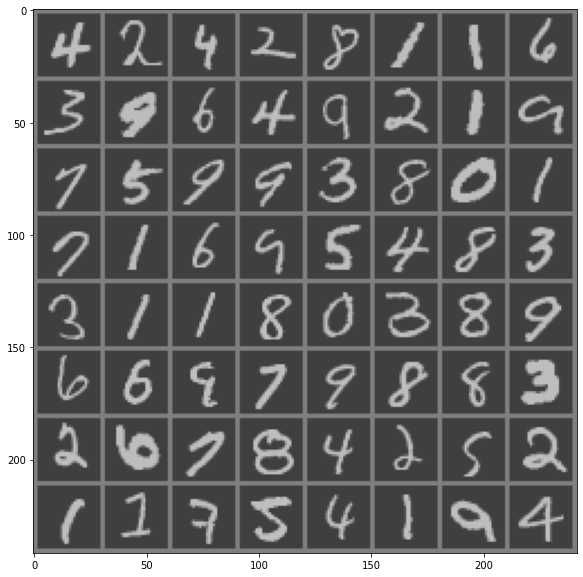

In [5]:
#@title PREVIEW THE DATA
def imshow(img):
  img = img / 2 + 0.5     
  npimg = img.numpy()
  plt.figure(figsize=(10, 10))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images, nrow=8))

In [6]:
#@title MODEL
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

In [7]:
#@title MODEL, OPTIMIZER and LOSS FUNCTION
model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.CrossEntropyLoss()

In [9]:
#@title TRAINING
liveloss = PlotLosses()
epochs = 10
history={}
for epoch in range(epochs):  
  avg_loss = 0
  for batch_idx, (x, y) in enumerate(train_loader):
    optimizer.zero_grad()    
    x, y = Variable(x), Variable(y)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    avg_loss = avg_loss * 0.9 + loss.data * 0.1
    history['avg_loss'] = avg_loss
    loss.backward()
    optimizer.step()   
    liveloss.update(history)
    liveloss.send() 
    

KeyboardInterrupt: ignored